# LIBRARIES
IMPORTING LIBRARIES

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,roc_curve, auc
from keras import callbacks

np.random.seed(0)

# LOADING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Replace with your actual file path
file_path = '/content/drive/My Drive/Case Study/weatherAUS.csv'

data = pd.read_csv(file_path)
data.head()


Mounted at /content/drive


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**About the data:**
The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations.

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
print(data['RainTomorrow'].unique())
print(data['RainTomorrow'].isnull().sum())

['No' 'Yes' nan]
3267


In [ ]:
#Imputing target columns is risky because you might introduce bias, so
data = data.dropna(subset=['RainTomorrow'])
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes': 1, 'No': 0})
print(data['RainTomorrow'].unique())

[0 1]


Points to notice:
1.   There are missing values in the dataset
2.   Dataset includes numeric and categorical values

# DATA VISUALIZATION AND CLEANING



1. Count plot of target column
2. Correlation amongst numeric attributes
3. Parse Dates into datetime
4. Encoding days and months as continuous cyclic features


In [ ]:
# Count the number of instances per class
print(data["RainTomorrow"].value_counts())

# Or to see it as percentages
print(data["RainTomorrow"].value_counts(normalize=True))


RainTomorrow
0    110316
1     31877
Name: count, dtype: int64
RainTomorrow
0    0.775819
1    0.224181
Name: proportion, dtype: float64


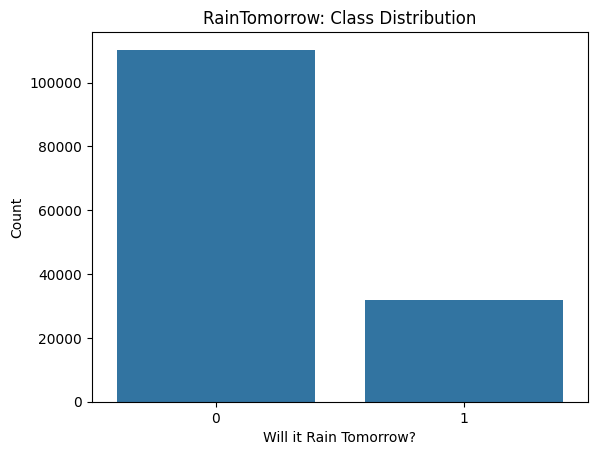

In [ ]:
# Plot the count of each class in the target column
sns.countplot(x='RainTomorrow', data=data)
plt.title('RainTomorrow: Class Distribution')
plt.xlabel('Will it Rain Tomorrow?')
plt.ylabel('Count')
plt.show()

We can observe that presence of "0" and "1" are almost in the ratio 78:22. So there is a class imbalance and we have to handle it. For tackling class imbalance, we will use oversampling of minority class here. Since the size of the data set is quite small, undersampling of majority class would not make much sense here.

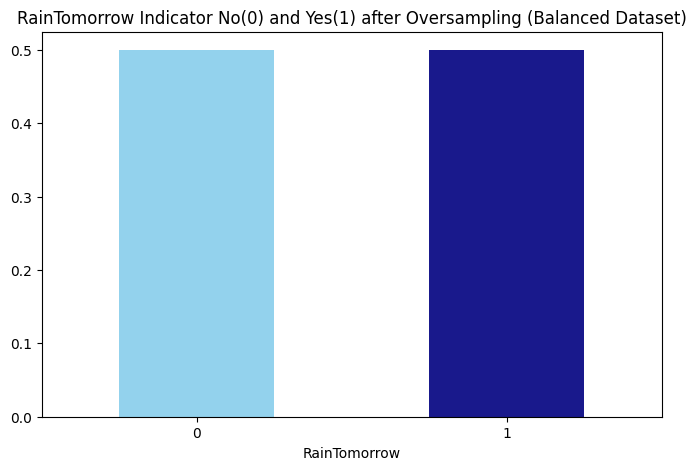

In [ ]:
from sklearn.utils import resample

no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

data = oversampled
#.sample(frac=1, random_state=42).reset_index(drop=True)


This helps you detect imbalance — crucial for deciding whether to use techniques like SMOTE or adjust class weights later.



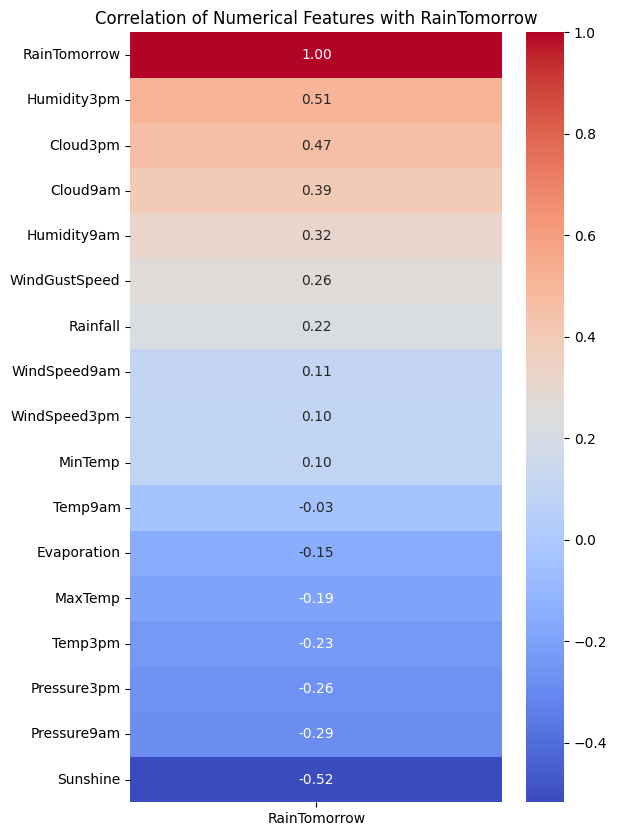

In [ ]:
# Select only numerical columns including 'RainTomorrow'
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr_matrix = data[numeric_cols].corr()

# Extract only correlation with 'RainTomorrow'
rain_corr = corr_matrix[['RainTomorrow']].sort_values(by='RainTomorrow', ascending=False)

# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(rain_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation of Numerical Features with RainTomorrow")
plt.show()


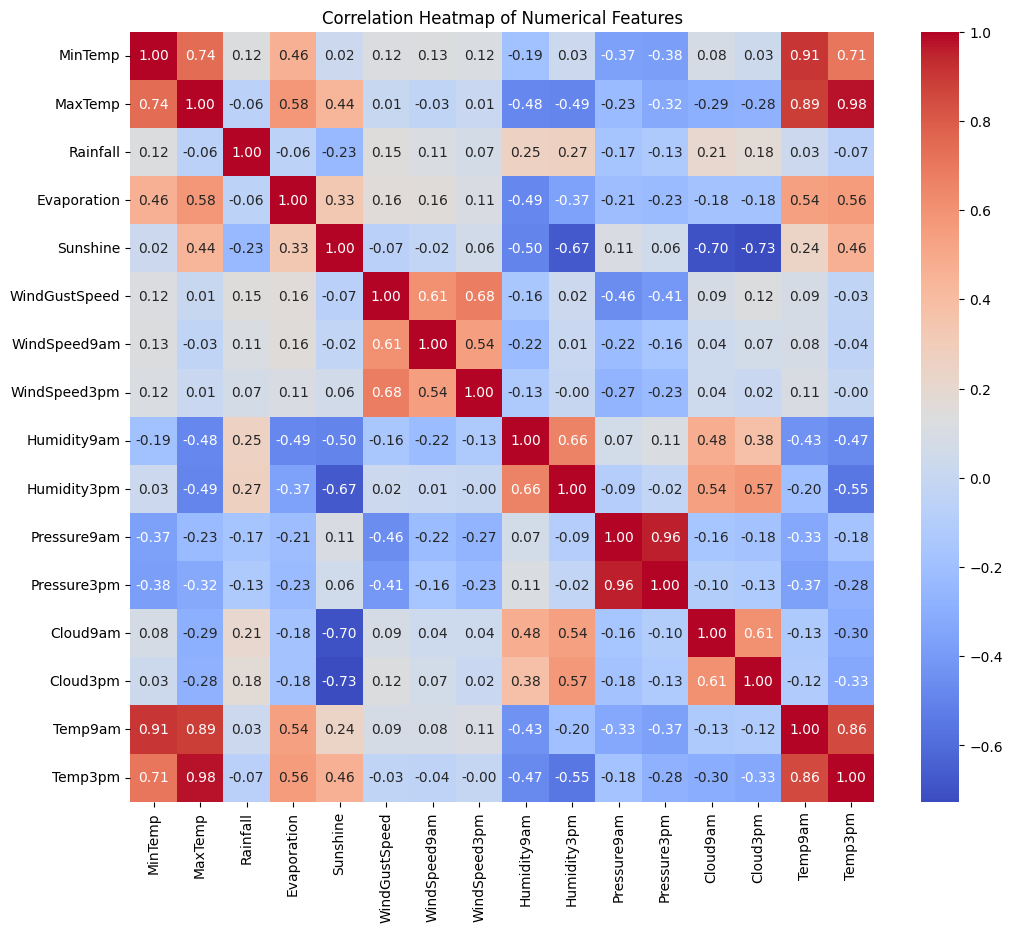

In [ ]:
# Compute correlation matrix for numerical features
numeric_cols = data.select_dtypes(include=['float64']).columns
corr_matrix = data[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


This is useful to spot redundant features, strong relationships, and even potential leakage.

| Feature        | Reason                                                                                |
| -------------- | ------------------------------------------------------------------------------------- |
| `Temp9am`      | Redundant with `Temp3pm` and `MaxTemp`                                                |
| `MaxTemp`      | Covered well by `Temp3pm`                                                             |
| `Pressure3pm`  | Drop, since `Pressure9am` is similar                                                  |
| `WindSpeed9am` | Redundant with `WindGustSpeed`                                                        |
| `Cloud9am`     | Similar to `Cloud3pm`, and may have NaNs                                              |
| `Evaporation`  | Usually high missing rate + low correlation                                           |
| `Sunshine`     | Only if too many NaNs, otherwise keep (good negative correlation with `RainTomorrow`) |


In [ ]:
drop_cols = [
    'Temp9am', 'MaxTemp', 'Pressure3pm',
    'WindSpeed9am', 'Cloud9am', 'Evaporation', 'Sunshine'  # Drop 'Sunshine' since it has high missing 46%
]

data = data.drop(columns=drop_cols)


**Now I will parse Dates into datetime.**

My goal is to build an artificial neural network(ANN). I will encode dates appropriately, i.e. I prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days. Now for each subsection, I create two new features, deriving a sine transform and cosine transform of the subsection feature.

In [ ]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

,count
Date,
10,220632


In [ ]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed3pm,Humidity9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,0.6,W,44.0,W,WNW,24.0,71.0,...,21.8,No,0,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,0.0,WNW,44.0,NNW,WSW,22.0,44.0,...,24.3,No,0,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,0.0,WSW,46.0,W,WSW,26.0,38.0,...,23.2,No,0,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,0.0,NE,24.0,SE,E,9.0,45.0,...,26.5,No,0,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,1.0,W,41.0,ENE,NW,20.0,82.0,...,29.7,No,0,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

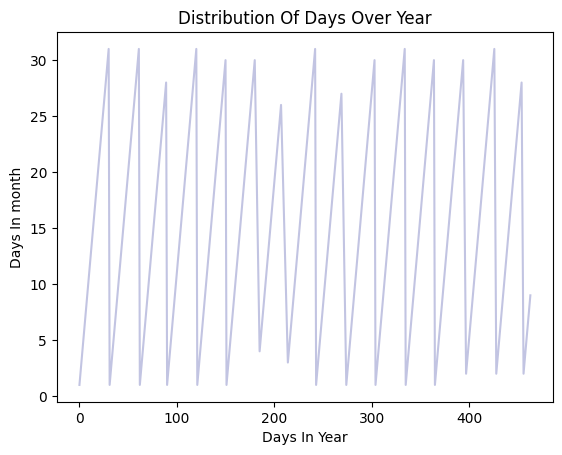

In [ ]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

As expected, the "year" attribute of data repeats. However in this for the true cyclic nature is not presented in a continuous manner. Splitting months and days into Sine and cosine combination provides the cyclical continuous feature. This can be used as input features to ANN.

Text(0.5, 0, 'Sine Encoded Months')

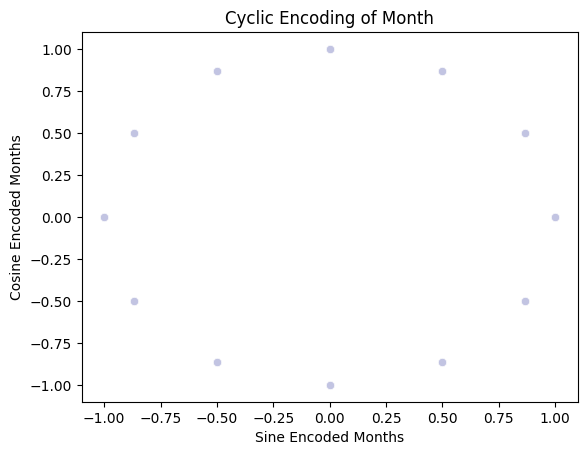

In [ ]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

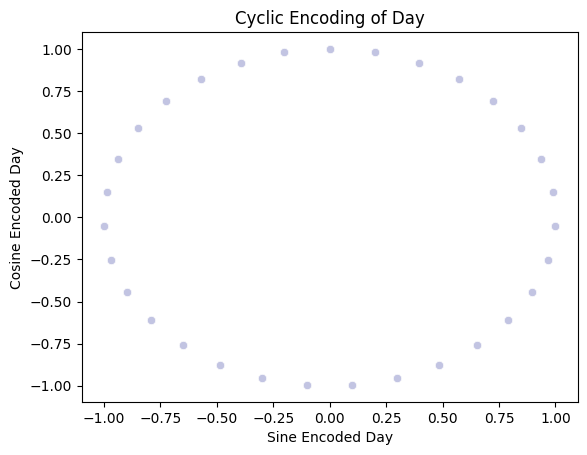

In [ ]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Next, I will deal with missing values in categorical and numeric attributes separately

**Categorical variables**

* Filling missing values with mode of the column value

In [ ]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [ ]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 15491
WindDir9am 14728
WindDir3pm 6440
RainToday 3124


In [ ]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

<ipython-input-19-c47c2d6da7f2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


**Numerical variables**

* Filling missing values with median of the column value

In [ ]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1082
Rainfall 3124
WindGustSpeed 15354
WindSpeed3pm 4353
Humidity9am 3171
Humidity3pm 6031
Pressure9am 21728
Cloud3pm 85614
Temp3pm 4558
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
for i in num_cols:
    print(f"{i}: Skewness = {data[i].skew():.2f}")

MinTemp: Skewness = 0.04
Rainfall: Skewness = 8.41
WindGustSpeed: Skewness = 0.81
WindSpeed3pm: Skewness = 0.65
Humidity9am: Skewness = -0.62
Humidity3pm: Skewness = -0.15
Pressure9am: Skewness = -0.12
Cloud3pm: Skewness = -0.61
Temp3pm: Skewness = 0.27
month_sin: Skewness = -0.01
month_cos: Skewness = 0.08
day_sin: Skewness = -0.00
day_cos: Skewness = 0.03


| Feature       | Missing Count | % Missing (approx) | Suggested Imputation Method                                             |
| ------------- | ------------- | ------------------ | ----------------------------------------------------------------------- |
| MinTemp       | 637           | \~0.44%            | Mean or Median (both fine, skewness \~0)                                |
| Rainfall      | 1406          | \~0.97%            | Median (high positive skew)                                             |  
| WindGustSpeed | 9270          | \~6.37%            | Median or mean                                                          |
| WindSpeed3pm  | 2630          | \~1.8%             | Median or mean                                                          |
| Humidity9am   | 1774          | \~1.22%            | Median or mean                                                          |
| Humidity3pm   | 3610          | \~2.48%            | Median or mean                                                          |
| Pressure9am   | 14014         | \~9.63%            | Median (slight negative skew)                                           |
| Cloud3pm      | 57094         | \~39.2%            | Consider dropping or imputing carefully                                 |
| Temp3pm       | 2726          | \~1.87%            | Mean or median                                                          |
| month\_sin    | 0             | 0%                 | No imputation needed                                                    |
| month\_cos    | 0             | 0%                 | No imputation needed                                                    |
| day\_sin      | 0             | 0%                 | No imputation needed                                                    |
| day\_cos      | 0             | 0%                 | No imputation needed                                                    |


In [ ]:
#data['Cloud3pm'] = data.groupby('Location')['Cloud3pm'].transform(lambda x: x.fillna(x.median()))

# If still any missing, fill with overall median or a fixed value
#data['Cloud3pm'] = data['Cloud3pm'].fillna(data['Cloud3pm'].median())



# Filling missing values with median of the column in value
#median_impute_cols = [col for col in num_cols if col != 'Cloud3pm']

for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)


data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 27220
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           220632 non-null  datetime64[ns]
 1   Location       220632 non-null  object        
 2   MinTemp        220632 non-null  float64       
 3   Rainfall       220632 non-null  float64       
 4   WindGustDir    220632 non-null  object        
 5   WindGustSpeed  220632 non-null  float64       
 6   WindDir9am     220632 non-null  object        
 7   WindDir3pm     220632 non-null  object        
 8   WindSpeed3pm   220632 non-null  float64       
 9   Humidity9am    220632 non-null  float64       
 10  Humidity3pm    220632 non-null  float64       
 11  Pressure9am    220632 non-null  float64       
 12  Cloud3pm       220632 non-null  float64       
 13  Temp3pm        220632 non-null  float64       
 14  RainToday      220632 non-null  object        
 15  RainTo

<ipython-input-23-2cff3bd734f5>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


Text(0.5, 0, 'Years')

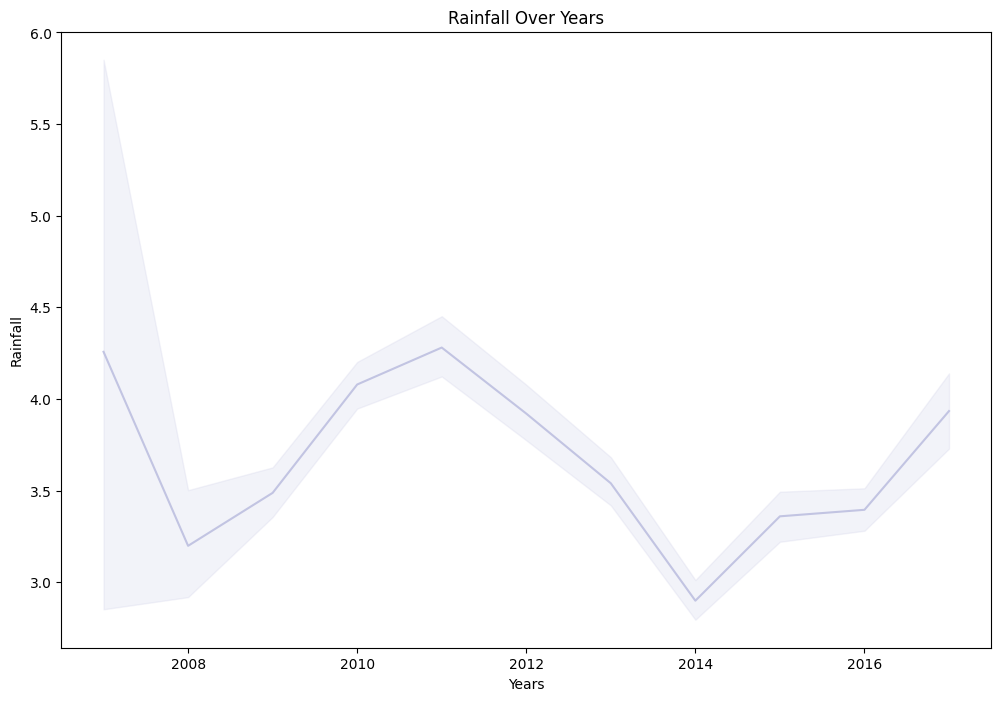

In [ ]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="#C2C4E2")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

<ipython-input-25-98c985829d42>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-25-98c985829d42>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-25-98c985829d42>:4: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)


Text(0.5, 0, 'Year')

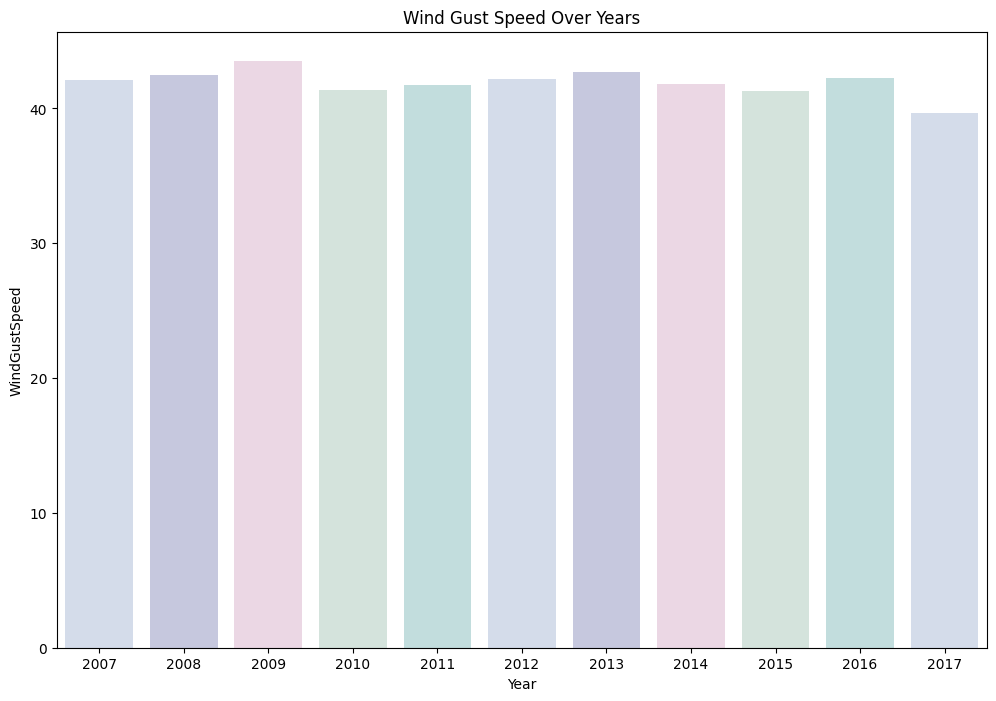

In [ ]:
#Evauating Wind gust speed over years
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

# DATA PREPROCESSING

**Steps involved in Data Preprocessing:**

* Label encoding columns with categorical data
* Perform the scaling of the features
* Detecting outliers
* Dropping the outliers based on data analysis

**Label encoding the catagorical varable**

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        unique_vals = data[col].unique()
        print(f"Column: {col} | Unique Values Count: {len(unique_vals)}")
        print(unique_vals)
        print("-" * 40)


Column: Location | Unique Values Count: 49
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
----------------------------------------
Column: WindGustDir | Unique Values Count: 16
['W' 'WNW' 'WSW' 'NE' 'SW' 'SSE' 'S' 'N' 'NNW' 'NW' 'SE' 'NNE' 'ESE' 'E'
 'SSW' 'ENE']
----------------------------------------
Column: WindDir9am | Unique Values Count: 16
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'N' 'WSW' 'NE' 'ESE' 'E' 'WNW' 'NNE'
 'NW' 'SSW']
-----------------------------

for directional variables like WindGustDir, WindDir9am, and WindDir3pm, cyclic encoding is often better than label encoding because directions are circular — e.g., North (N) and East (E) are closer to Northeast (NE), and after 360° it loops back to 0°.

Why cyclic encoding?
It preserves the cyclic nature of directions.

Prevents the model from interpreting, say, N (0) and WNW (15) as very far apart when they are close on a compass.

In [ ]:
# Compass directions mapping to degrees
direction_degrees = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

def cyclic_encode_direction(col):
    angles = data[col].map(direction_degrees)
    data[col + '_sin'] = np.sin(2 * np.pi * angles / 360)
    data[col + '_cos'] = np.cos(2 * np.pi * angles / 360)
    data.drop(columns=[col], inplace=True)

# Apply cyclic encoding to wind direction columns
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    cyclic_encode_direction(col)

In [ ]:
data = pd.get_dummies(data, columns=['Location'], drop_first=True)

In [ ]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['RainToday']


In [ ]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    # Since missing values (NaNs) have already been filled,
    # there is no risk of errors during label encoding.
    # Therefore, we can directly apply fit_transform on the column.
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 27220
Data columns (total 73 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       220632 non-null  datetime64[ns]
 1   MinTemp                    220632 non-null  float64       
 2   Rainfall                   220632 non-null  float64       
 3   WindGustSpeed              220632 non-null  float64       
 4   WindSpeed3pm               220632 non-null  float64       
 5   Humidity9am                220632 non-null  float64       
 6   Humidity3pm                220632 non-null  float64       
 7   Pressure9am                220632 non-null  float64       
 8   Cloud3pm                   220632 non-null  float64       
 9   Temp3pm                    220632 non-null  float64       
 10  RainToday                  220632 non-null  int64         
 11  RainTomorrow               220632 non-null  int64         

In [ ]:
# Preparing the feature set for modeling
# Dropping the target variable 'RainTomorrow', 'Date', and the original 'day' and 'month' columns
# because 'day_sin', 'day_cos', 'month_sin', and 'month_cos' (cyclic encodings) are already included.
features = data.drop(['RainTomorrow', 'Date', 'day', 'month'], axis=1)

# Separating the target variable
target = data['RainTomorrow']


for col in features:
    unique_vals = data[col].unique()
    print(f"Column: {col} | Unique Values Count: {len(unique_vals)}")
    print(unique_vals)
    print("-" * 40)


Column: MinTemp | Unique Values Count: 388
[13.4  7.4 12.9  9.2 17.5 14.6 14.3  7.7 13.1 12.6  9.8 11.2 11.5 17.1
 20.5 15.3 16.2 16.9 20.1 12.5 12.  11.3  9.6 10.5 12.3 13.7 16.1 14.
 17.  17.3 17.2 17.4 19.8 14.9 13.9 18.6 19.3 18.8 20.8 15.7 18.5 20.4
 21.8 22.3 22.  28.  24.4 21.5 21.7 23.5 28.3 18.4 13.5 12.4 13.3 18.
 18.7 15.5  8.9 15.  15.4 16.  12.8 13.2 13.8  7.6  8.3 11.  10.   8.8
  8.4  9.3 14.4 10.8 10.1  9.1 10.4 12.2 10.7  7.8  8.1  7.5  8.2  9.9
  3.5  6.6  7.   5.7  6.2  6.   5.4  2.1  1.8  7.2  4.6  4.2  5.2  4.1
  3.2  4.3  3.7  3.6  6.9  3.   2.6  5.1  4.4  4.7  6.7 11.6  8.   2.2
  2.8 -2.  -1.3  2.   0.5  1.2  0.6  5.   3.4  0.  -1.5 -1.7 -0.4  0.1
  4.8  2.9 -0.6 -0.3 -1.   0.8 -0.1  6.5 -0.8  1.9  6.8  1.6  5.5  1.1
  1.   6.3  4.5  1.7  4.   3.8  6.4 10.6  5.9 14.5 15.6 17.8 15.9 16.7
 18.1 12.1 11.4 18.3 11.9 11.1 14.2  9.  11.8 13.6 12.7 15.1 17.6 14.8
 16.3 19.6 20.6 21.  24.5 16.8  8.7 19.2 24.7 17.7 15.2 18.9 17.9 19.5
 20.3 23.  22.5 16.4 20.2 18.2 16.5 

In [ ]:
# Columns to exclude from scaling (e.g., target, date, encoded categoricals, sin/cos features, etc.)
exclude_cols = [
    'Date', 'RainToday', 'RainTomorrow', 'month', 'day',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'WindGustDir_sin', 'WindGustDir_cos',
    'WindDir9am_sin', 'WindDir9am_cos',
    'WindDir3pm_sin', 'WindDir3pm_cos'
]

# Dynamically detect float columns
numerical_cols = data.select_dtypes(include=['float64','int32','int64']).columns.tolist()

# Filter out columns that should not be scaled
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# Show columns that will be scaled
print("📦 Columns to scale:", numerical_cols)

📦 Columns to scale: ['MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'year']


In [ ]:
# Setting up StandardScaler to normalize the feature values
# StandardScaler transforms the features to have mean=0 and std=1, which helps many ML algorithms converge faster
#
scaler = StandardScaler()
features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

joblib.dump(scaler, 'scaler.joblib')

# Display summary statistics of scaled features to verify scaling
features.describe().T


,count,mean,std,min,25%,50%,75%,max
MinTemp,220632.0,-2.622766e-16,1.000002,-3.298043,-0.709272,-5.031260e-02,0.734163,3.354313
Rainfall,220632.0,-7.213893e-18,1.000002,-0.327556,-0.327556,-3.275559e-01,-0.128651,33.215121
WindGustSpeed,220632.0,-7.420005e-17,1.000002,-2.549228,-0.636012,-6.913295e-02,0.568606,6.591695
WindSpeed3pm,220632.0,4.740559e-17,1.000002,-2.100371,-0.674726,-1.673615e-02,0.531589,7.440483
Humidity9am,220632.0,2.432113e-16,1.000002,-3.908873,-0.602730,1.018576e-01,0.806445,1.511033
Humidity3pm,220632.0,4.946670e-17,1.000002,-2.677243,-0.679613,1.723485e-02,0.714083,1.968408
Pressure9am,220632.0,-1.820787e-14,1.000002,-5.156686,-0.601028,6.628209e-04,0.616680,3.510525
Cloud3pm,220632.0,1.298501e-16,1.000002,-2.637237,-0.242346,2.366322e-01,0.715610,1.673567
Temp3pm,220632.0,-8.491783e-16,1.000002,-3.811500,-0.724422,-9.827005e-02,0.673499,3.775138
RainToday,220632.0,3.052912e-01,0.460532,0.000000,0.000000,0.000000e+00,1.000000,1.000000


<ipython-input-34-21937fb5bce9>:6: UserWarning: 
The palette list has fewer values (5) than needed (65) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data=boxen_features, palette=colours)


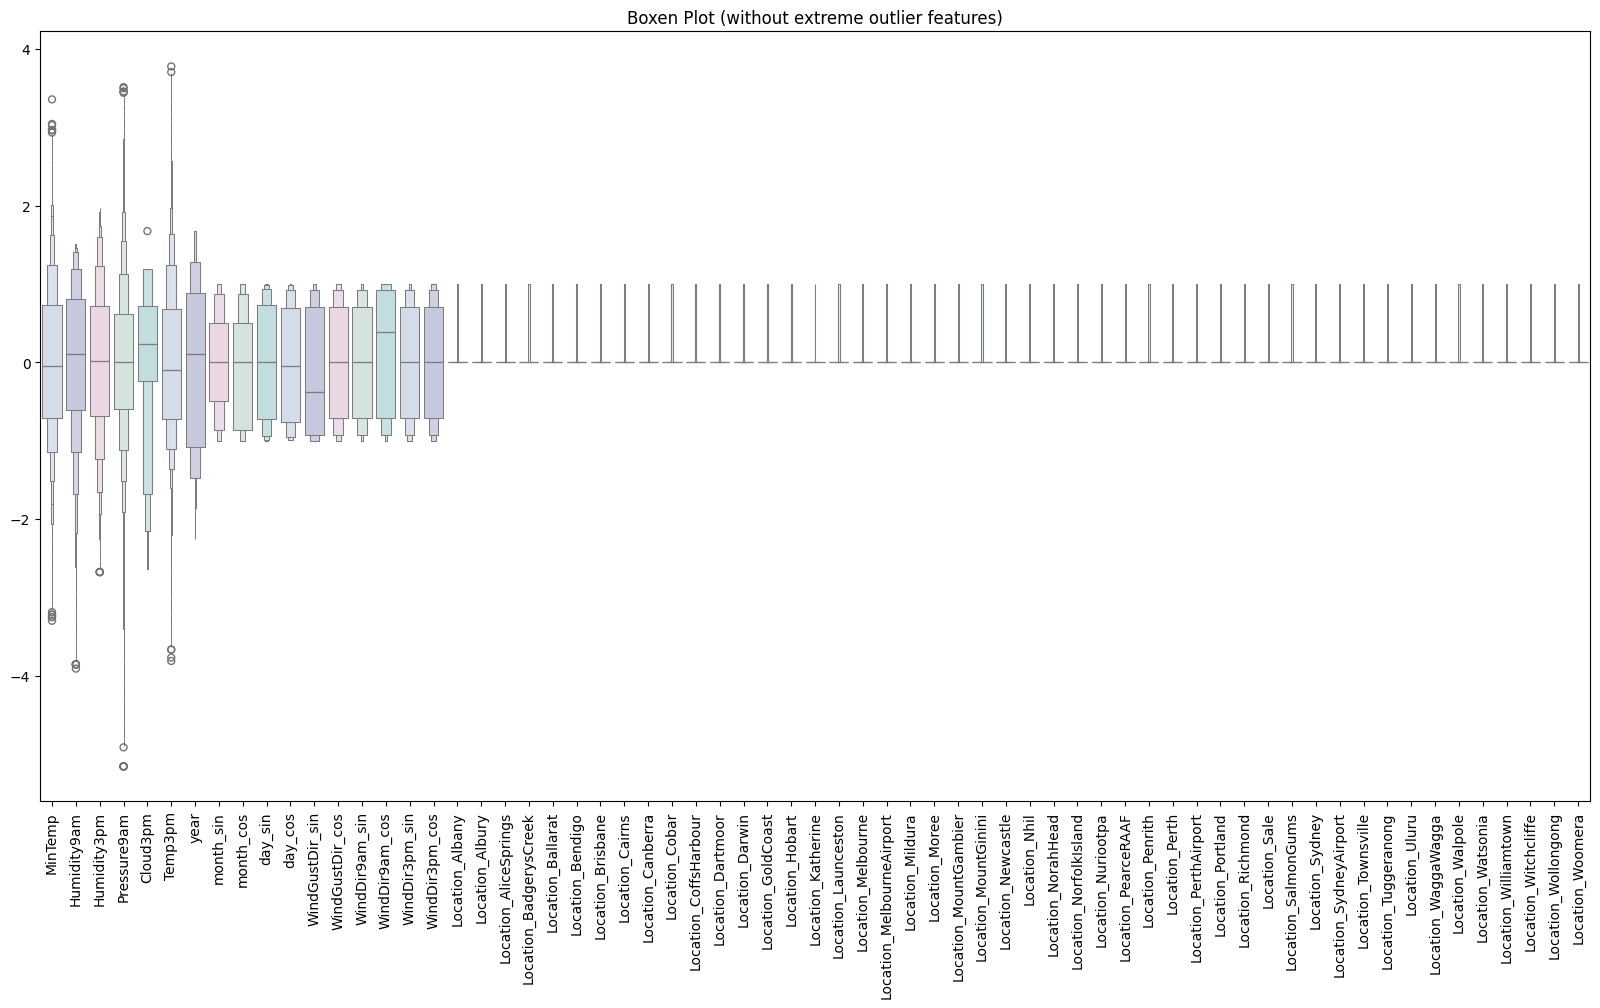

In [ ]:
# Drop extreme features just for the plot
outlier_sensitive = ['Rainfall', 'WindSpeed3pm', 'WindGustSpeed', 'RainToday']
boxen_features = features.drop(columns=outlier_sensitive)

plt.figure(figsize=(20, 10))
sns.boxenplot(data=boxen_features, palette=colours)
plt.xticks(rotation=90)
plt.title("Boxen Plot (without extreme outlier features)")
plt.show()


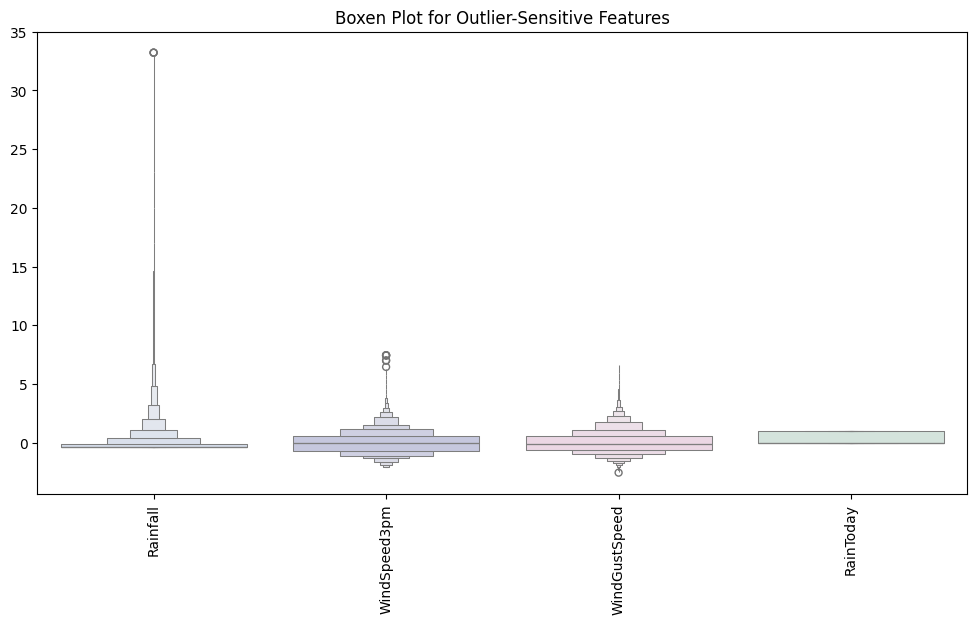

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxenplot(data=features[outlier_sensitive], palette=colours[:len(outlier_sensitive)])
plt.xticks(rotation=90)
plt.title("Boxen Plot for Outlier-Sensitive Features")
plt.show()


In [ ]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["Rainfall"]<4.3)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Cloud3pm"]<1.5)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(198500, 70)

<ipython-input-37-0b9d7aa52ee8>:4: UserWarning: 
The palette list has fewer values (5) than needed (70) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


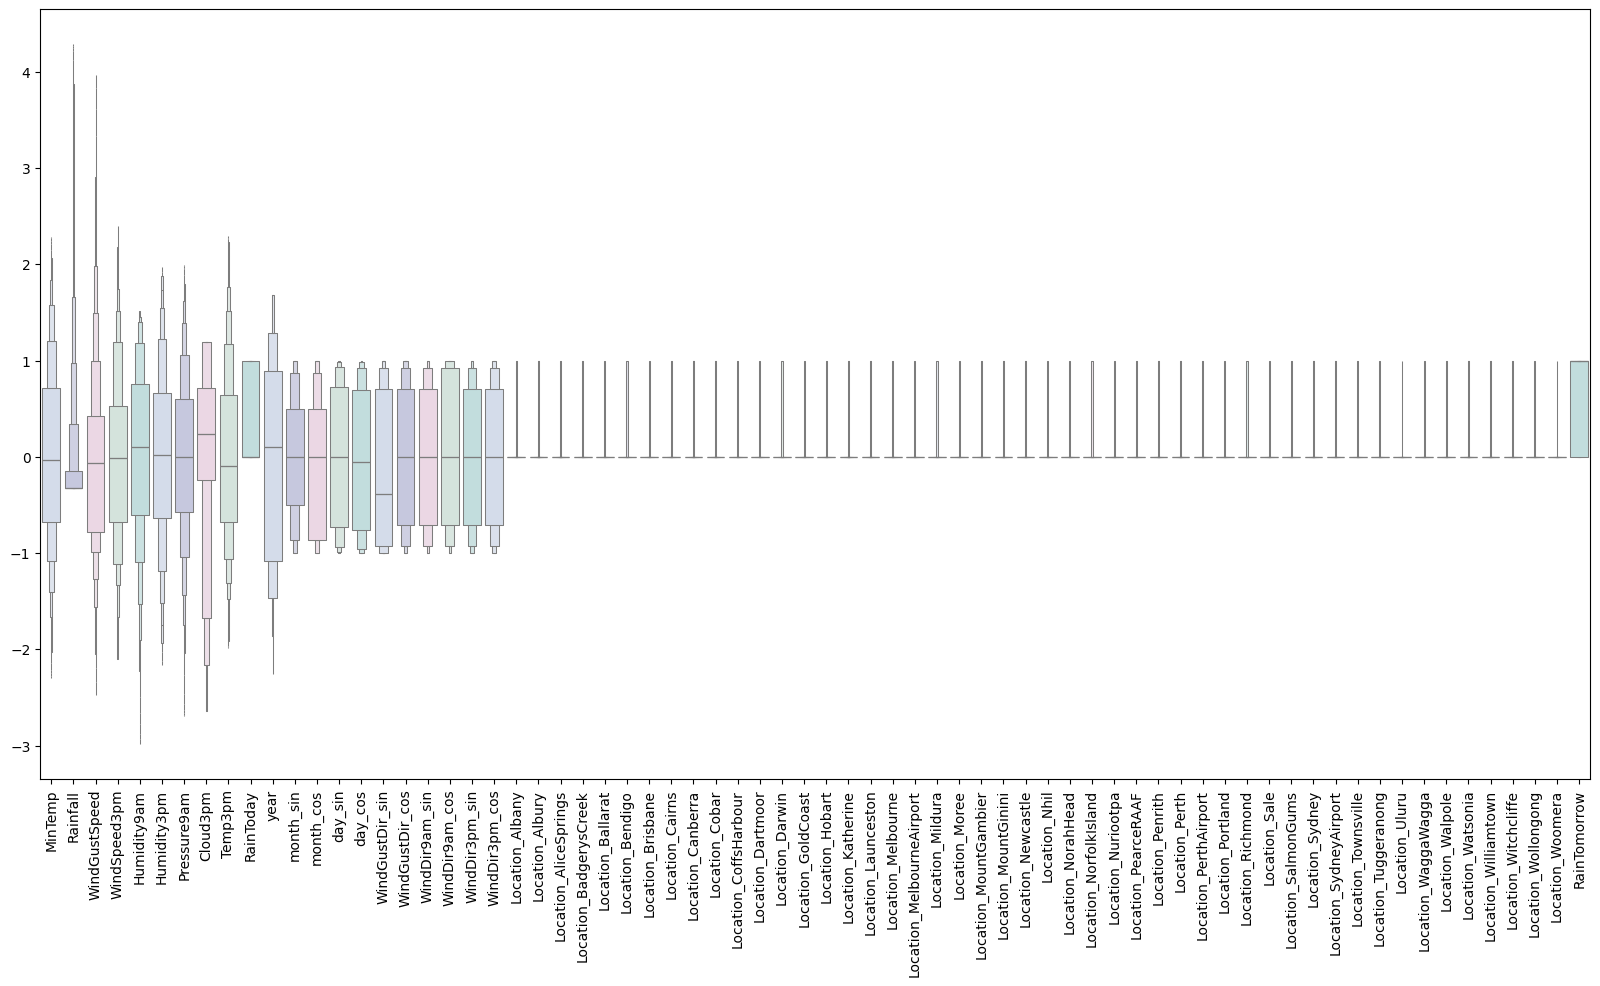

In [ ]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Calculate correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than threshold (e.g., 0.8)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop those features
features_reduced = features.drop(columns=to_drop)

print("Dropped columns due to high correlation:", to_drop)
print("Remaining features:", features_reduced.columns)


Dropped columns due to high correlation: []
Remaining features: Index(['MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday',
       'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'Location_Albany',
       'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek',
       'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane',
       'Location_Cairns', 'Location_Canberra', 'Location_Cobar',
       'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin',
       'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine',
       'Location_Launceston', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle',
       'Location_Nhil'

Looks Good. Up next is building artificial neural network.


# MODEL BUILDING


**In this project, we build an artificial neural network.**

**Following steps are involved in the model building**

* Assining X and y the status of attributes and tags
* Splitting test and training sets
* Initialising the neural network
* Defining by adding layers
* Compiling the neural network
* Train the neural network

In [ ]:
X = features_reduced.drop(["RainTomorrow"], axis=1)
y = features_reduced["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


X.shape

(198500, 69)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()
model.add(Dense(64, kernel_initializer='he_normal', activation='relu', input_dim=69))
model.add(BatchNormalization())

model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())

model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

opt = Adam(learning_rate=0.00009)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])



model.summary()
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150,
                    callbacks=[early_stopping], validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6771 - auc: 0.7373 - loss: 0.6242 - val_accuracy: 0.7625 - val_auc: 0.8423 - val_loss: 0.4904
Epoch 2/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7544 - auc: 0.8346 - loss: 0.5038 - val_accuracy: 0.7771 - val_auc: 0.8575 - val_loss: 0.4687
Epoch 3/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7702 - auc: 0.8503 - loss: 0.4805 - val_accuracy: 0.7830 - val_auc: 0.8649 - val_loss: 0.4578
Epoch 4/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7742 - auc: 0.8558 - loss: 0.4723 - val_accuracy: 0.7882 - val_auc: 0.8694 - val_loss: 0.4511
Epoch 5/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7800 - auc: 0.8621 - loss: 0.4629 - val_accuracy: 0.7907 - val_auc: 0.8724 - val_loss: 0.4465
Epoch 6/150
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7817 - auc: 0.8632 - loss: 0.4615 - val_accuracy: 0.7924 - val_auc: 0.8748 - val_loss: 0.4424
Epoch 7/150
3970

Plotting training and validation loss over epochs

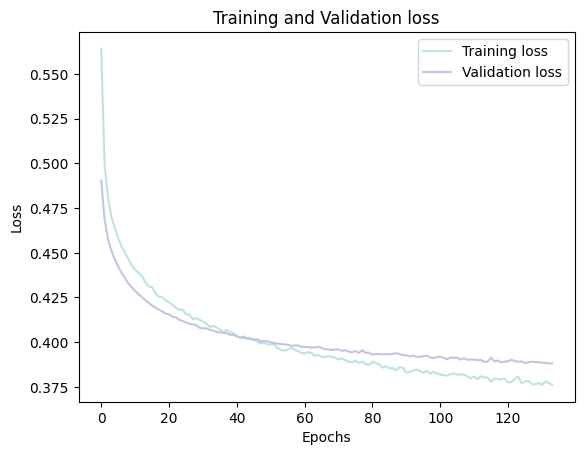

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

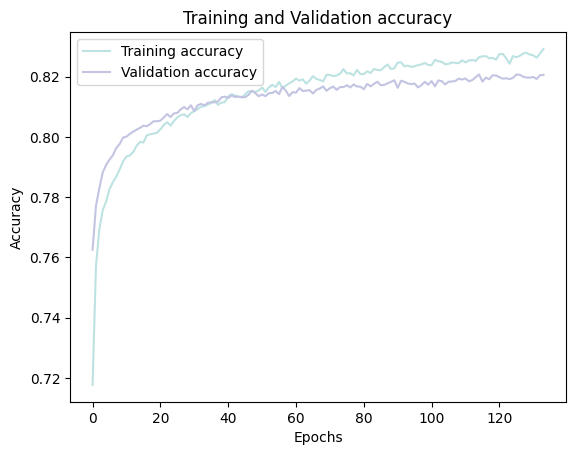

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1241/1241 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


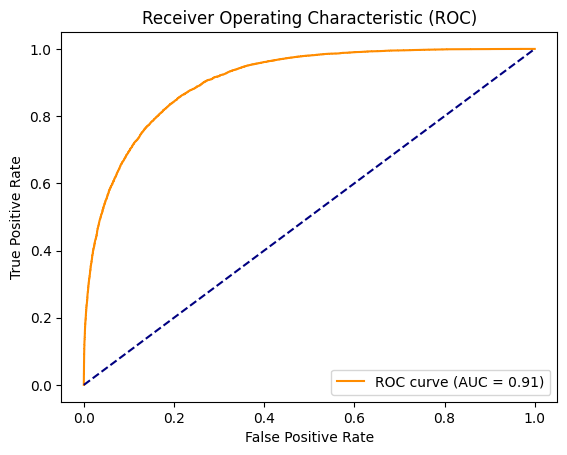

In [ ]:
# Predict probabilities
y_pred_proba = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# CONCLUSIONS


**Concluding the model with:**

* Testing on the test set
* Evaluating the confusion matrix
* Evaluating the classification report

In [ ]:
probs = model.predict(X_test)
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    preds = (probs > t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_t = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_t:.2f}")


1241/1241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Best Threshold: 0.38


In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.41)

1241/1241 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

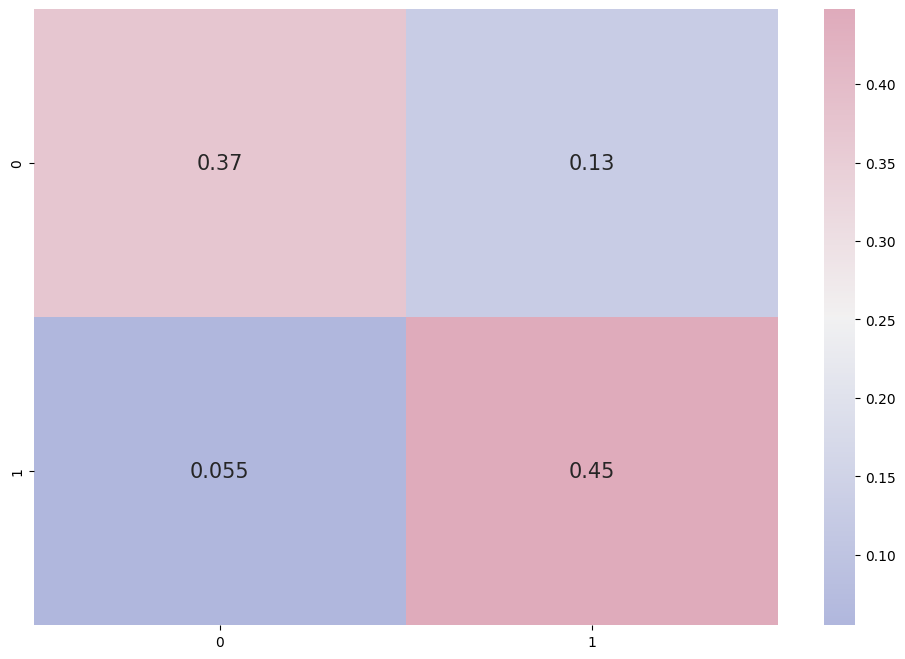

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     19740
           1       0.78      0.89      0.83     19960

    accuracy                           0.82     39700
   macro avg       0.82      0.82      0.82     39700
weighted avg       0.82      0.82      0.82     39700



In [ ]:
# Save the trained model
model.save('model.h5')


# XGBoost
is known for handling imbalanced datasets well and often outperforms neural networks for tabular data like yours.

Here's a step-by-step guide to train an XGBoost model for your binary classification task: